## Bengali.Ai : Multi_Output_DenseNet121 (keras)

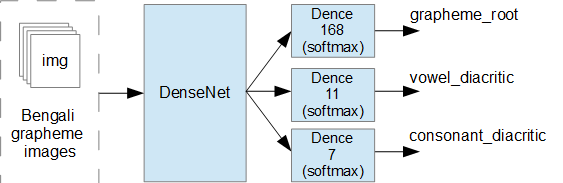<BR>
<BR>
    I referred to [kaushl Shah : Starter EDA+ Multi Output CNN](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn). Thanks.<BR><BR>
This kernel has changed the Model from my [previous kernel](https://www.kaggle.com/amanooo/bengali-ai-multi-output-densenet-keras). 
- Change a small DenseNet built by myself to **DenseNet121**.
- And I used locally trained model to avoid GPU time limits.

In [ ]:
import os
from tqdm.auto import tqdm
import time, gc

import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt
%matplotlib inline
import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Input, load_model
from keras.layers import Dense, Conv2D, Flatten, Activation, Concatenate
from keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.initializers import RandomNormal
from keras.applications import DenseNet121

from sklearn.model_selection import train_test_split

start_time = time.time()

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Setting execution conditions

In [ ]:
### Kaggle or Local-PC ###
KAGGLE = True       # <==== SET ============
if KAGGLE:
    DIR = '../input/bengaliai-cv19'
    DIRwork = '../input/mywork'
else:               # local PC
    DIR = './bengaliai-cv19'
    DIRwork = './'

In [ ]:
### Train or Predict ###
TRAIN = False        # <==== SET ============
# True : Do training (GPU time limit over), model save.
# False: Load trained model and do prediction.

if TRAIN:
    print('==TRAIN mode==\n Training Model takes several hours and does not meet the GPU time limit for competition.')
else:
    # Check file existence
    if os.path.isfile(os.path.join(DIRwork,"dense.h5")) \
            and os.path.isfile(os.path.join(DIRwork,"hist.csv")):
        print('==Not TRAIN mode (Predict only)==')
    else:
        print("==ERROR==\n No 'Model file' and/or 'history file'.\n Upload the files to '../input/bengaliai-cv19/mywork'.")

### Read Data Files

In [ ]:
# read CSV files
train_df = pd.read_csv(os.path.join(DIR,'train.csv'))
test_df = pd.read_csv(os.path.join(DIR,'test.csv'))
class_map_df = pd.read_csv(os.path.join(DIR,'class_map.csv'))
sample_sub_df = pd.read_csv(os.path.join(DIR,'sample_submission.csv'))
                            
# read Parquet Format Image file (example)
img_df = pd.read_parquet(os.path.join(DIR,'train_image_data_0.parquet'))

In [ ]:
print(train_df.shape)
train_df.head()

In [ ]:
print(test_df.shape)
test_df.head()

In [ ]:
print(class_map_df.shape)
class_map_df.head()

In [ ]:
print(sample_sub_df.shape)
sample_sub_df.head()

In [ ]:
print(img_df.shape)
img_df.head()

`Column['0': '32331']` of img_df has flattened image size `137 * 236 (= 32332)`

## Observe each data

In [ ]:
# target columns
tgt_cols = ['grapheme_root','vowel_diacritic','consonant_diacritic']

In [ ]:
def get_top(tgt, n, top=True):
    top_df = train_df.groupby([tgt]).size().reset_index(name='counts') \
                            ['counts'].sort_values(ascending=not top)[:n].copy()
    top_ids = top_df.index
    top_vals = top_df.values
    
    top_df = class_map_df.iloc[top_ids].copy()
    top_df.drop(['component_type', 'label'], axis=1, inplace=True)
    top_df['count'] = top_vals
    return top_df

In [ ]:
def disp_img(df, ids):
    r_n = len(ids)  # character count
    c_n = 5         # num of examples for each character
    plt.figure()
    fig, ax = plt.subplots(r_n, c_n, figsize=(12, 10))
    for r, id in enumerate(ids[:r_n]):
        sumple_ids = train_df[train_df['grapheme_root'] == id].index
        for c, sumple_id in enumerate(sumple_ids[:c_n]):
            flattened_image = df.iloc[sumple_id].drop('image_id').values.astype(np.uint8)
            ax[r, c%c_n].imshow(flattened_image.reshape([137, 236]))
            ax[r, c%c_n].set_title(str(id)+'(Train_'+str(sumple_id)+')')

### Summarize training data

In [ ]:
desc_df = train_df[tgt_cols].astype('str').describe()
desc_df

In [ ]:
# Number of unique types
types = desc_df.loc['unique',:]

### Top used Grapheme Root

In [ ]:
top_roots = get_top('grapheme_root', 10)
top_roots

In [ ]:
# Top 5 example
disp_img(img_df, top_roots.index[:5])

### Top used Vowel Diacritic

In [ ]:
top_vowels = get_top('vowel_diacritic', 10)
top_vowels

In [ ]:
# Top 5 example
disp_img(img_df, top_vowels.index[:5])

### Top used Consonant Diacritic

In [ ]:
top_consonants = get_top('consonant_diacritic', 10)
top_consonants

In [ ]:
disp_img(img_df, top_consonants.index[:5])

## Multi Output DenseNet Models
Prepare DenceNet models with three-outputs (for 'grapheme root', 'vowel diacritic' and 'consonant_diacritic')

In [ ]:
SIZE = 64    # input image size
N_ch = 1

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    grapheme_root = Dense(types['grapheme_root'],
                          activation = 'softmax', name='root')(x)
    vowel_diacritic = Dense(types['vowel_diacritic'],
                            activation = 'softmax', name='vowel')(x)
    consonant_diacritic = Dense(types['consonant_diacritic'],
                                activation = 'softmax', name='consonant')(x)

    # model
    model = Model(input,
                  [grapheme_root, vowel_diacritic, consonant_diacritic])
    
    return model

Training Model takes several hours and does not meet the **GPU time limit** for competition. Therefore, this Karnel uses a pretrained-Model.<BR>If you want to Training yourself, set `TRAIN = True`.

In [ ]:
if TRAIN:
    # build model
    model = build_denseNet()
    
    # compile
    model.compile(Adam(lr=0.002),
              loss={'root': 'categorical_crossentropy',
                    'vowel': 'categorical_crossentropy',
                    'consonant': 'categorical_crossentropy'},
              loss_weights={'root': 0.333,        ## Set weights
                            'vowel': 0.333,
                            'consonant': 0.333},
              metrics={'root': 'accuracy',
                       'vowel': 'accuracy',
                       'consonant': 'accuracy'}
             )
else:
    # Load pretrained-Model
    model = load_model(os.path.join(DIRwork, 'dense.h5'))

In [ ]:
model.summary()

## Training
### Prepare Training Data

In [ ]:
# Clip horizontally
def clip(img):
    cols = np.any(img < 200, axis=0)
    xleft, xright = np.where(cols)[0][[0, -1]]
    width = xright - xleft
    center = int((xleft + xright) / 2)
    
    if width < 137:
        img = img[:, max(0, center - 70):min(center + 70, 236)]
    else:
        img = img[:, max(0, xleft - 2):min(xright + 2, 236)]
        
    return img

In [ ]:
# Resize image size
def resize(df, size=64):
    resized = {}
    for i in range(df.shape[0]):
        img = clip(df.loc[df.index[i]].values.reshape(137,236))
        image = cv2.resize(img,(size,size))
        resized[df.index[i]] = image.reshape(-1)
    resized_df = pd.DataFrame(resized).T
    return resized_df

In [ ]:
if TRAIN:
    # prepare X
    img_df = img_df.drop(['image_id'], axis = 1)
    X_df = (resize(img_df, SIZE) / 255.).astype('float32')
    del img_df
    gc.collect()
    for i in tqdm(range(1,4)):
        img_df = pd.read_parquet(os.path.join(
            DIR, 'train_image_data_'+str(i)+'.parquet'))
        img_df = img_df.drop(['image_id'], axis = 1)
        img_df = (resize(img_df, SIZE) / 255.).astype('float32')
        X_df = pd.concat([X_df, img_df], axis = 0)
        del img_df
        gc.collect()
    
    X_train = X_df.values.reshape(-1, SIZE, SIZE, N_ch)
    del X_df
    gc.collect()

In [ ]:
if TRAIN:
    # prepare Y
    train_df = train_df[tgt_cols].astype('uint8')
    for col in tgt_cols:
        train_df[col] = train_df[col].map('{:03}'.format)
    Y_train = pd.get_dummies(train_df)

    del train_df
    gc.collect()

In [ ]:
if TRAIN:
    # Divide the data into train and val set
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train,
                                                test_size=0.1, random_state=42)
    y_train_root = y_train.iloc[:,0:types['grapheme_root']]
    y_train_vowel = y_train.iloc[:,types['grapheme_root']:types['grapheme_root']+types['vowel_diacritic']]
    y_train_consonant = y_train.iloc[:,types['grapheme_root']+types['vowel_diacritic']:]
    y_test_root = y_test.iloc[:,0:types['grapheme_root']]
    y_test_vowel = y_test.iloc[:,types['grapheme_root']:types['grapheme_root']+types['vowel_diacritic']]
    y_test_consonant = y_test.iloc[:,types['grapheme_root']+types['vowel_diacritic']:]
    
    del X_train, Y_train
    gc.collect()

In [ ]:
print(time.time() - start_time,'[sec]')

### Fit

In [ ]:
batch_size = 128
epochs = 30           ## set epochs

In [ ]:
# Callback : Learning Rate annealer
reduceLR = ReduceLROnPlateau(monitor = 'val_root_loss',
                             patience = 2,
                             factor = 0.5,
                             min_lr = 1e-5,
                             verbose = 1)
# Callback : Save best model
chkPoint = ModelCheckpoint('dense.h5',
                           monitor = 'val_root_accuracy',
                           save_best_only = True,
                           save_weights_only = False,
                           mode = 'auto',
                           period = 1,
                           verbose = 0)
# Callback : Early Stop
earlyStop = EarlyStopping(monitor='val_root_accuracy',
                          mode = 'auto',
                          patience = 4,
                          min_delta = 0,
                          verbose = 1)

In [ ]:
if TRAIN:
    history = model.fit(x_train,
                    {'root': y_train_root,
                     'vowel': y_train_vowel,
                     'consonant': y_train_consonant},
                    batch_size = batch_size,
                    epochs = epochs,
                    shuffle = True,
                    validation_data = (x_test,
                                       {'root': y_test_root,
                                        'vowel': y_test_vowel,
                                        'consonant': y_test_consonant}),
                    callbacks = [reduceLR, chkPoint, earlyStop],
                    verbose = 1)

    del x_train, x_test, y_train, y_test
    gc.collect()

In [ ]:
if TRAIN:
    df = pd.DataFrame(history.history)
    df.to_csv('hist.csv',index=False)
else:
    df = pd.read_csv(os.path.join(DIRwork,'hist.csv'))
    
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(df[['root_loss','vowel_loss','consonant_loss',
               'val_root_loss','val_vowel_loss','val_consonant_loss']])
ax[0].set_ylim(0, 2)
ax[0].set_title('Loss')
ax[0].legend(['train_root_loss','train_vowel_loss','train_conso_loss',
              'val_root_loss','val_vowel_loss','val_conso_loss'],
             loc='upper right')
ax[0].grid()
ax[1].plot(df[['root_acc','vowel_acc','consonant_acc',
               'val_root_acc','val_vowel_acc','val_consonant_acc']])
ax[1].set_ylim(0.5, 1)
ax[1].set_title('Accuracy')
ax[1].legend(['train_root_acc','train_vowel_acc','train_conso_acc',
              'val_root_acc','val_vowel_acc','val_conso_acc'],
             loc='lower right')
ax[1].grid()

In [ ]:
print(time.time() - start_time, '[sec]')

## Predict and Submit

In [ ]:
row_ids = []
targets = []      # prediction result
id = 0
for i in range(4):
    img_df = pd.read_parquet(os.path.join(
                            DIR, 'test_image_data_'+str(i)+'.parquet'))
    img_df = img_df.drop('image_id', axis = 1)
    img_df = resize(img_df, SIZE) / 255.
    X_test = img_df.values.reshape(-1, SIZE, SIZE, N_ch)

    preds = model.predict(X_test)
    for j in range(len(X_test)):
        for k in range(3):
            row_ids.append('Test_'+str(id)+'_'+tgt_cols[k])
            targets.append(np.argmax(preds[k][j]))
        id += 1

In [ ]:
submit_df = pd.DataFrame({'row_id':row_ids,'target':targets},
                         columns = ['row_id','target'])
submit_df.head(10)

In [ ]:
print(time.time() - start_time,'[sec]')

In [ ]:
submit_df.to_csv('submission.csv',index=False)